In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
torch.manual_seed(42)

In [6]:
train = datasets.FashionMNIST(root='data', train=True, download=False, transform=transforms.ToTensor())
test = datasets.FashionMNIST(root='data', train=False, download=False, transform=transforms.ToTensor())

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [7]:
class FashionCNN(nn.Module):
    def __init__(self, input_features):
        super(FashionCNN, self).__init__()
        self.features = nn.Sequential(
			nn.Conv2d(input_features, 32, kernel_size=3, stride=1, padding='same'),
	 		nn.ReLU(),
			nn.BatchNorm2d(32),
			nn.MaxPool2d(kernel_size=(2, 2), stride=2),
   
			nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
			nn.ReLU(),
			nn.BatchNorm2d(64),
			nn.MaxPool2d(kernel_size=(2, 2), stride=2),
   
		)
        self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear(in_features=64 * 7 * 7, out_features=128),
			nn.ReLU(),
			nn.Dropout(0.4),
   
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Dropout(0.4),
			nn.Linear(64, 10)
		)
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
model = FashionCNN(1).to(device)

criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 	

In [9]:
import time

epoch = 10

start_time = time.time()

for i in range(epoch):
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.reshape(-1, 1, 28, 28)  # Flatten the images
        output = model(img)
        loss = criterian(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: {}, Loss: {}".format(i, loss.item()))

print("Training completed in {} seconds".format(time.time() - start_time))

Epoch: 0, Loss: 0.24344556033611298
Epoch: 1, Loss: 0.37859469652175903
Epoch: 2, Loss: 0.1332421749830246
Epoch: 3, Loss: 0.282206267118454
Epoch: 4, Loss: 0.10959196090698242
Epoch: 5, Loss: 0.2556884288787842
Epoch: 6, Loss: 0.21164508163928986
Epoch: 7, Loss: 0.05758284404873848
Epoch: 8, Loss: 0.3879019021987915
Epoch: 9, Loss: 0.08142612129449844
Training completed in 88.85866165161133 seconds


In [10]:
model.eval()

FashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [11]:
# test acc
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        img = img.reshape(-1, 1, 28, 28)
        output = model(img)
        loss = criterian(output, label)
        
        _, pred = torch.max(output, 1)
        accuracy = torch.sum(pred == label).item() / len(label)
        
print("Accuracy: ", accuracy)
  

Accuracy:  0.9375


In [12]:
# training acc
with torch.no_grad():
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        img = img.reshape(-1, 1, 28, 28)
        output = model(img)
        loss = criterian(output, label)
        
        _, pred = torch.max(output, 1)
        accuracy = torch.sum(pred == label).item() / len(label)
        
print("Accuracy: ", accuracy)
  

Accuracy:  0.90625


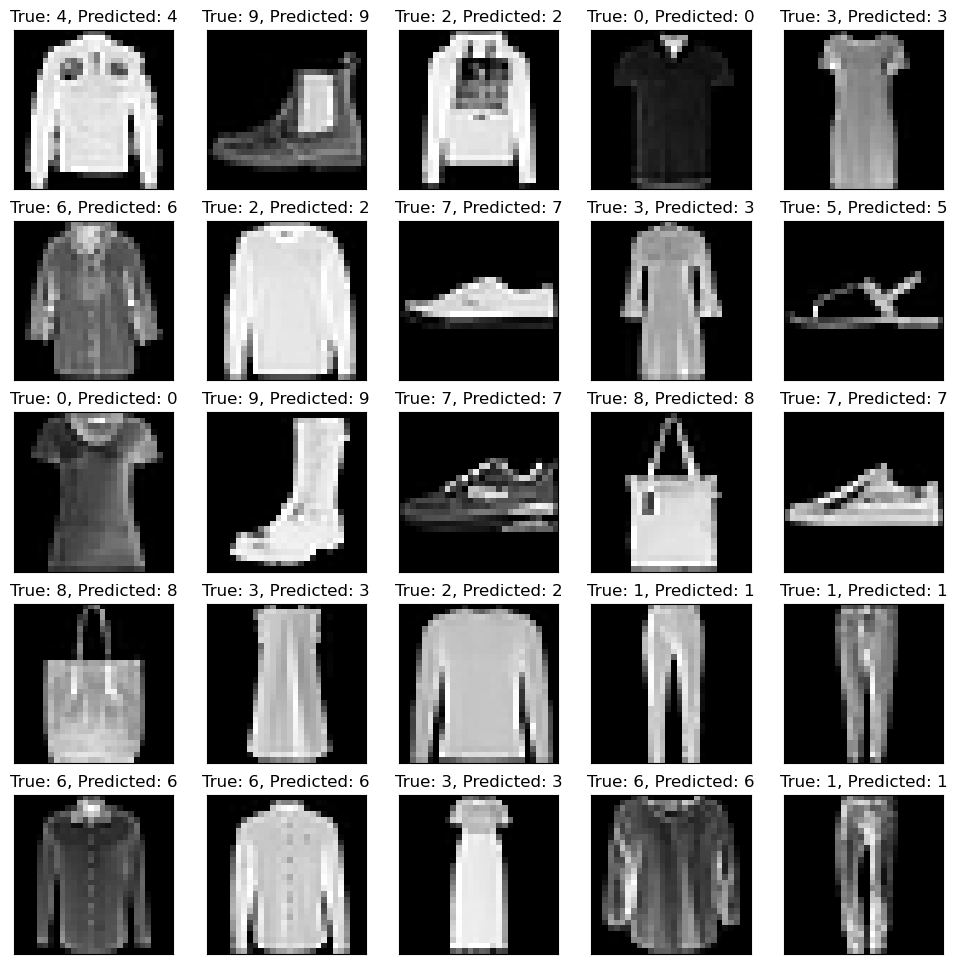

In [15]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
images = images.reshape(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)

with torch.no_grad():
	output = model(images)
	predicted = torch.max(output, 1)[1]
	labels = labels.numpy()
	predicted = predicted.cpu().numpy()

fig = plt.figure(figsize=(12, 12))
for i in range(25):
	ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
	ax.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
	ax.set_title("True: {}, Predicted: {}".format(labels[i], predicted[i]))